<a href="https://colab.research.google.com/github/HelloShagun/useful_libs/blob/main/examples/end_to_end_Lakes_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github cloning and setting Notebook

In [1]:
!git clone https://github.com/HelloShagun/useful_libs


Cloning into 'useful_libs'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 3), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 1.37 MiB | 4.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [18]:
from google.colab import output
output.enable_custom_widget_manager()

In [20]:
import sys
sys.path.append("/content/useful_libs/")

In [21]:
#### Raster Path
tif_file_path = '/content/sample_data/Water_Mask_Comparison_Figure (1).tif'

### Packages


In [1]:
!pip install contextily

In [2]:
import os, sys, importlib
import numpy as np
import pandas as pd

In [3]:
# ---- 0) Point Python to your repo (so relative imports work) ----
REPO_DIR = "/content/useful_libs"   # <-- change if your clone path differs
PKG_DIR  = os.path.join(REPO_DIR, "lake_maps_comparison")

assert os.path.isdir(REPO_DIR), f"Repo not found at: {REPO_DIR}"
assert os.path.isdir(PKG_DIR),  f"lake_maps_comparison not found at: {PKG_DIR}"

# Ensure package init exists (required for relative imports like from .morphology import ...)
init_path = os.path.join(PKG_DIR, "__init__.py")
if not os.path.exists(init_path):
    with open(init_path, "w") as f:
        f.write("# lake_maps_comparison package\n")

if REPO_DIR not in sys.path:
    sys.path.insert(0, REPO_DIR)

print("✅ Repo on sys.path:", REPO_DIR)

✅ Repo on sys.path: /content/useful_libs


In [4]:

from lake_maps_comparison.io_stack import read_stack, get_band_mask
from lake_maps_comparison.morphology import MorphologyConfig, clean_mask
from lake_maps_comparison.objects import ObjectConfig, label_and_stats
from lake_maps_comparison.matching import MatchConfig, union_masks, match_objects_labels_to_mask
from lake_maps_comparison.vectorize import labels_to_geodataframe
from lake_maps_comparison.wayback_export import export_wayback_panels, ExportStyle, export_wayback_page

In [5]:
# Optional (only if you have it)
try:
    from lake_maps_comparison.fragmentation_ecdf import plot_ecdf_raw_vs_consolidated
    HAS_ECDF = True
except Exception as e:
    HAS_ECDF = False
    print("ℹ️ fragmentation_ecdf not available (ok):", repr(e))

# Optional (only if you have it)
try:
    from lake_maps_comparison.wayback_export import export_wayback_maps
    HAS_WAYBACK = True
except Exception as e:
    HAS_WAYBACK = False
    print("ℹ️ wayback_export not available (ok):", repr(e))

ℹ️ wayback_export not available (ok): ImportError("cannot import name 'export_wayback_maps' from 'lake_maps_comparison.wayback_export' (/content/useful_libs/lake_maps_comparison/wayback_export.py)")


In [76]:
###

### Input /Output

In [6]:
# ---- 2) USER CONFIG (edit these) ----
TIF_PATH = "/content/sample_data/Water_Mask_Comparison_Figure (1).tif"  # <-- your stack
OUT_DIR  = "/content/lake_maps_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

BASE_PRODUCTS = ["SARL_Water", "ESA_Water", "JRC_Water", "DW_Water", "HydroLAKES"]
AE_MAIN = "AE_ge_70"


### Parameters

In [7]:
# Comparison switchboard (edit only this)
SOURCE_OBJECTS = "AE_ge_70"     # objects to evaluate (label from this mask)
REFERENCE_MODE = "SINGLE"          # "ANY" or "SINGLE"
REFERENCE_MASK = "ESA_Water"    # used if SINGLE
#REFERENCE_MASKS = ["SARL_Water", "ESA_Water", "JRC_Water", "DW_Water", "HydroLAKES"]  # used if ANY


In [8]:

# Cleaning / consolidation knobs
morph_cfg = MorphologyConfig(
    pixel_size_m=10.0,
    merge_dist_m=30.0,     # merge fragments within ~30 m
    min_area_m2=300.0,     # drop tiny speckles
    fill_holes=True,
    connectivity=4
)

# Object extraction knobs
obj_cfg = ObjectConfig(
    connectivity=4,
    pixel_area_m2=100.0    # 10 m pixels -> 100 m^2
)

# Matching knobs
match_cfg = MatchConfig(
    pixel_size_m=10.0,
    dist_tol_m=30.0,
    overlap_frac_tol=0.10,
    connectivity=4
)

# ---- 4) Wayback export knobs (paper-ready) ----
WAYBACK_DATE = "2021-01-13"
WAYBACK_OUT_DIR = os.path.join(OUT_DIR, "wayback_pngs")
os.makedirs(WAYBACK_OUT_DIR, exist_ok=True)

style = ExportStyle(
    pad_m=250,
    dpi=450,
    draw_coords=True,
    draw_scalebar=True,
    draw_north_arrow=True,
)

WAYBACK_MODE = "grouped"   # "grouped" or "individual"
GROUP_EPS_M = 400          # only matters if grouped
ID_FIELD = "obj_id"        # optional if your geojson contains it

## Final Code

In [13]:
######### MAke Directories ect
COMPARISON_TAG = f"{SOURCE_OBJECTS}_vs_{REFERENCE_MASK if REFERENCE_MODE=='SINGLE' else 'ANY'}"

# ---- Comparison-specific output directories ----
COMP_OUT_DIR = os.path.join(OUT_DIR, COMPARISON_TAG)
TABLE_DIR = os.path.join(COMP_OUT_DIR, "tables")
GEOJSON_DIR = os.path.join(COMP_OUT_DIR, "geojson")
WAYBACK_OUT_DIR = os.path.join(COMP_OUT_DIR, "wayback_pngs")

for d in [COMP_OUT_DIR, TABLE_DIR, GEOJSON_DIR, WAYBACK_OUT_DIR]:
    os.makedirs(d, exist_ok=True)




# ---- 5) Read stack ----
arr, meta = read_stack(TIF_PATH)
print("✅ Stack loaded:", arr.shape)
print("✅ Bands:", meta.band_desc)

# ---- 6) Build cleaned masks dict (only those we need) ----
# Ensure we include all masks that might be referenced
needed = set([SOURCE_OBJECTS])
if REFERENCE_MODE == "ANY":
    needed.update(REFERENCE_MASKS)
else:
    needed.add(REFERENCE_MASK)

masks = {}
for name in needed:
    raw = get_band_mask(arr, meta.band_desc, name)
    masks[name] = clean_mask(raw, morph_cfg, pixel_area_m2=obj_cfg.pixel_area_m2, return_intermediate=False)

print("✅ Built masks:", list(masks.keys()))

# ---- 7) Label SOURCE objects + stats ----
src_stats, src_inter = label_and_stats(masks[SOURCE_OBJECTS], obj_cfg, return_intermediate=True)
src_lab = src_inter["labels"]
print(f"✅ Source objects ({SOURCE_OBJECTS}):", src_inter["n"])

# ---- 8) Build reference mask ----
if REFERENCE_MODE == "ANY":
    ref_mask = union_masks(masks, REFERENCE_MASKS)
    ref_name = "ANY"
else:
    ref_mask = masks[REFERENCE_MASK]
    ref_name = REFERENCE_MASK

print("✅ Reference mask:", ref_name)

# ---- 9) Match source objects to reference mask ----
per_obj = match_objects_labels_to_mask(src_lab, ref_mask, match_cfg)
per_obj = per_obj.merge(src_stats, on="obj_id", how="left")

new_objs_df = per_obj[~per_obj["matched"]].copy()

summary = {
    "source": SOURCE_OBJECTS,
    "reference": ref_name,
    "n_source_objects": int(len(per_obj)),
    "n_new_objects": int(len(new_objs_df)),
    "fraction_new": float(len(new_objs_df) / len(per_obj)) if len(per_obj) else np.nan,
    "new_area_ha_total": float(new_objs_df["area_ha"].sum()) if "area_ha" in new_objs_df else np.nan,
    "new_area_ha_median": float(new_objs_df["area_ha"].median()) if len(new_objs_df) else np.nan,
}
summary_df = pd.DataFrame([summary])

print("✅ Summary\n", summary_df)

# Save tables
summary_df.to_csv(os.path.join(TABLE_DIR, "summary.csv"), index=False)
per_obj.to_csv(os.path.join(TABLE_DIR, "objects_all.csv"), index=False)
new_objs_df.to_csv(os.path.join(TABLE_DIR, "objects_new.csv"), index=False)

# ---- 10) Vectorize SOURCE objects to GeoDataFrame, then subset "new" ones ----
src_gdf = labels_to_geodataframe(
    label_image=src_lab,
    obj_stats=src_stats,
    transform=meta.transform,
    crs=meta.crs,
)

new_ids = new_objs_df["obj_id"].astype(int).unique()
new_gdf = src_gdf[src_gdf["obj_id"].isin(new_ids)].copy()

print("✅ New objects GeoDataFrame:", new_gdf.shape, "CRS:", new_gdf.crs)

# ---- 11) IMPORTANT: save GeoJSON first (your exporter expects a path) ----
tmp_geojson = os.path.join(GEOJSON_DIR, "new_objects.geojson")
new_gdf.to_file(tmp_geojson, driver="GeoJSON")
print("✅ Saved GeoJSON:", tmp_geojson)

# ---- 12) Export Wayback panels from the saved GeoJSON ----
saved = export_wayback_panels(
    polygons_path=tmp_geojson,
    out_dir=WAYBACK_OUT_DIR,
    wayback_date=WAYBACK_DATE,
    mode=WAYBACK_MODE,          # "grouped" or "individual"
    group_eps_m=GROUP_EPS_M,    # only matters if grouped
    id_field=ID_FIELD,
    style=style,
)

print(f"✅ Wayback exports saved: {len(saved)} PNG(s)")
print("Example:", saved[:1])

print("\nDONE ✅ Outputs in:", OUT_DIR)


✅ Stack loaded: (10, 1178, 1467)
✅ Bands: ['SARL_Water', 'ESA_Water', 'JRC_Water', 'DW_Water', 'HydroLAKES', 'AE_ge_60', 'AE_ge_65', 'AE_ge_70', 'AE_ge_75', 'AE_ge_80']
✅ Built masks: ['AE_ge_70', 'ESA_Water']
✅ Source objects (AE_ge_70): 136
✅ Reference mask: ESA_Water


✅ Summary
      source  reference  n_source_objects  n_new_objects  fraction_new  \
0  AE_ge_70  ESA_Water               136             99      0.727941   

   new_area_ha_total  new_area_ha_median  
0              35.65                0.14  
✅ New objects GeoDataFrame: (99, 5) CRS: EPSG:4326
✅ Saved GeoJSON: /content/lake_maps_outputs/AE_ge_70_vs_ESA_Water/geojson/new_objects.geojson


FileNotFoundError: [Errno 2] No such file or directory: '/content/wayback_pngs/AE_new_ONE_PAGE_2021.png'

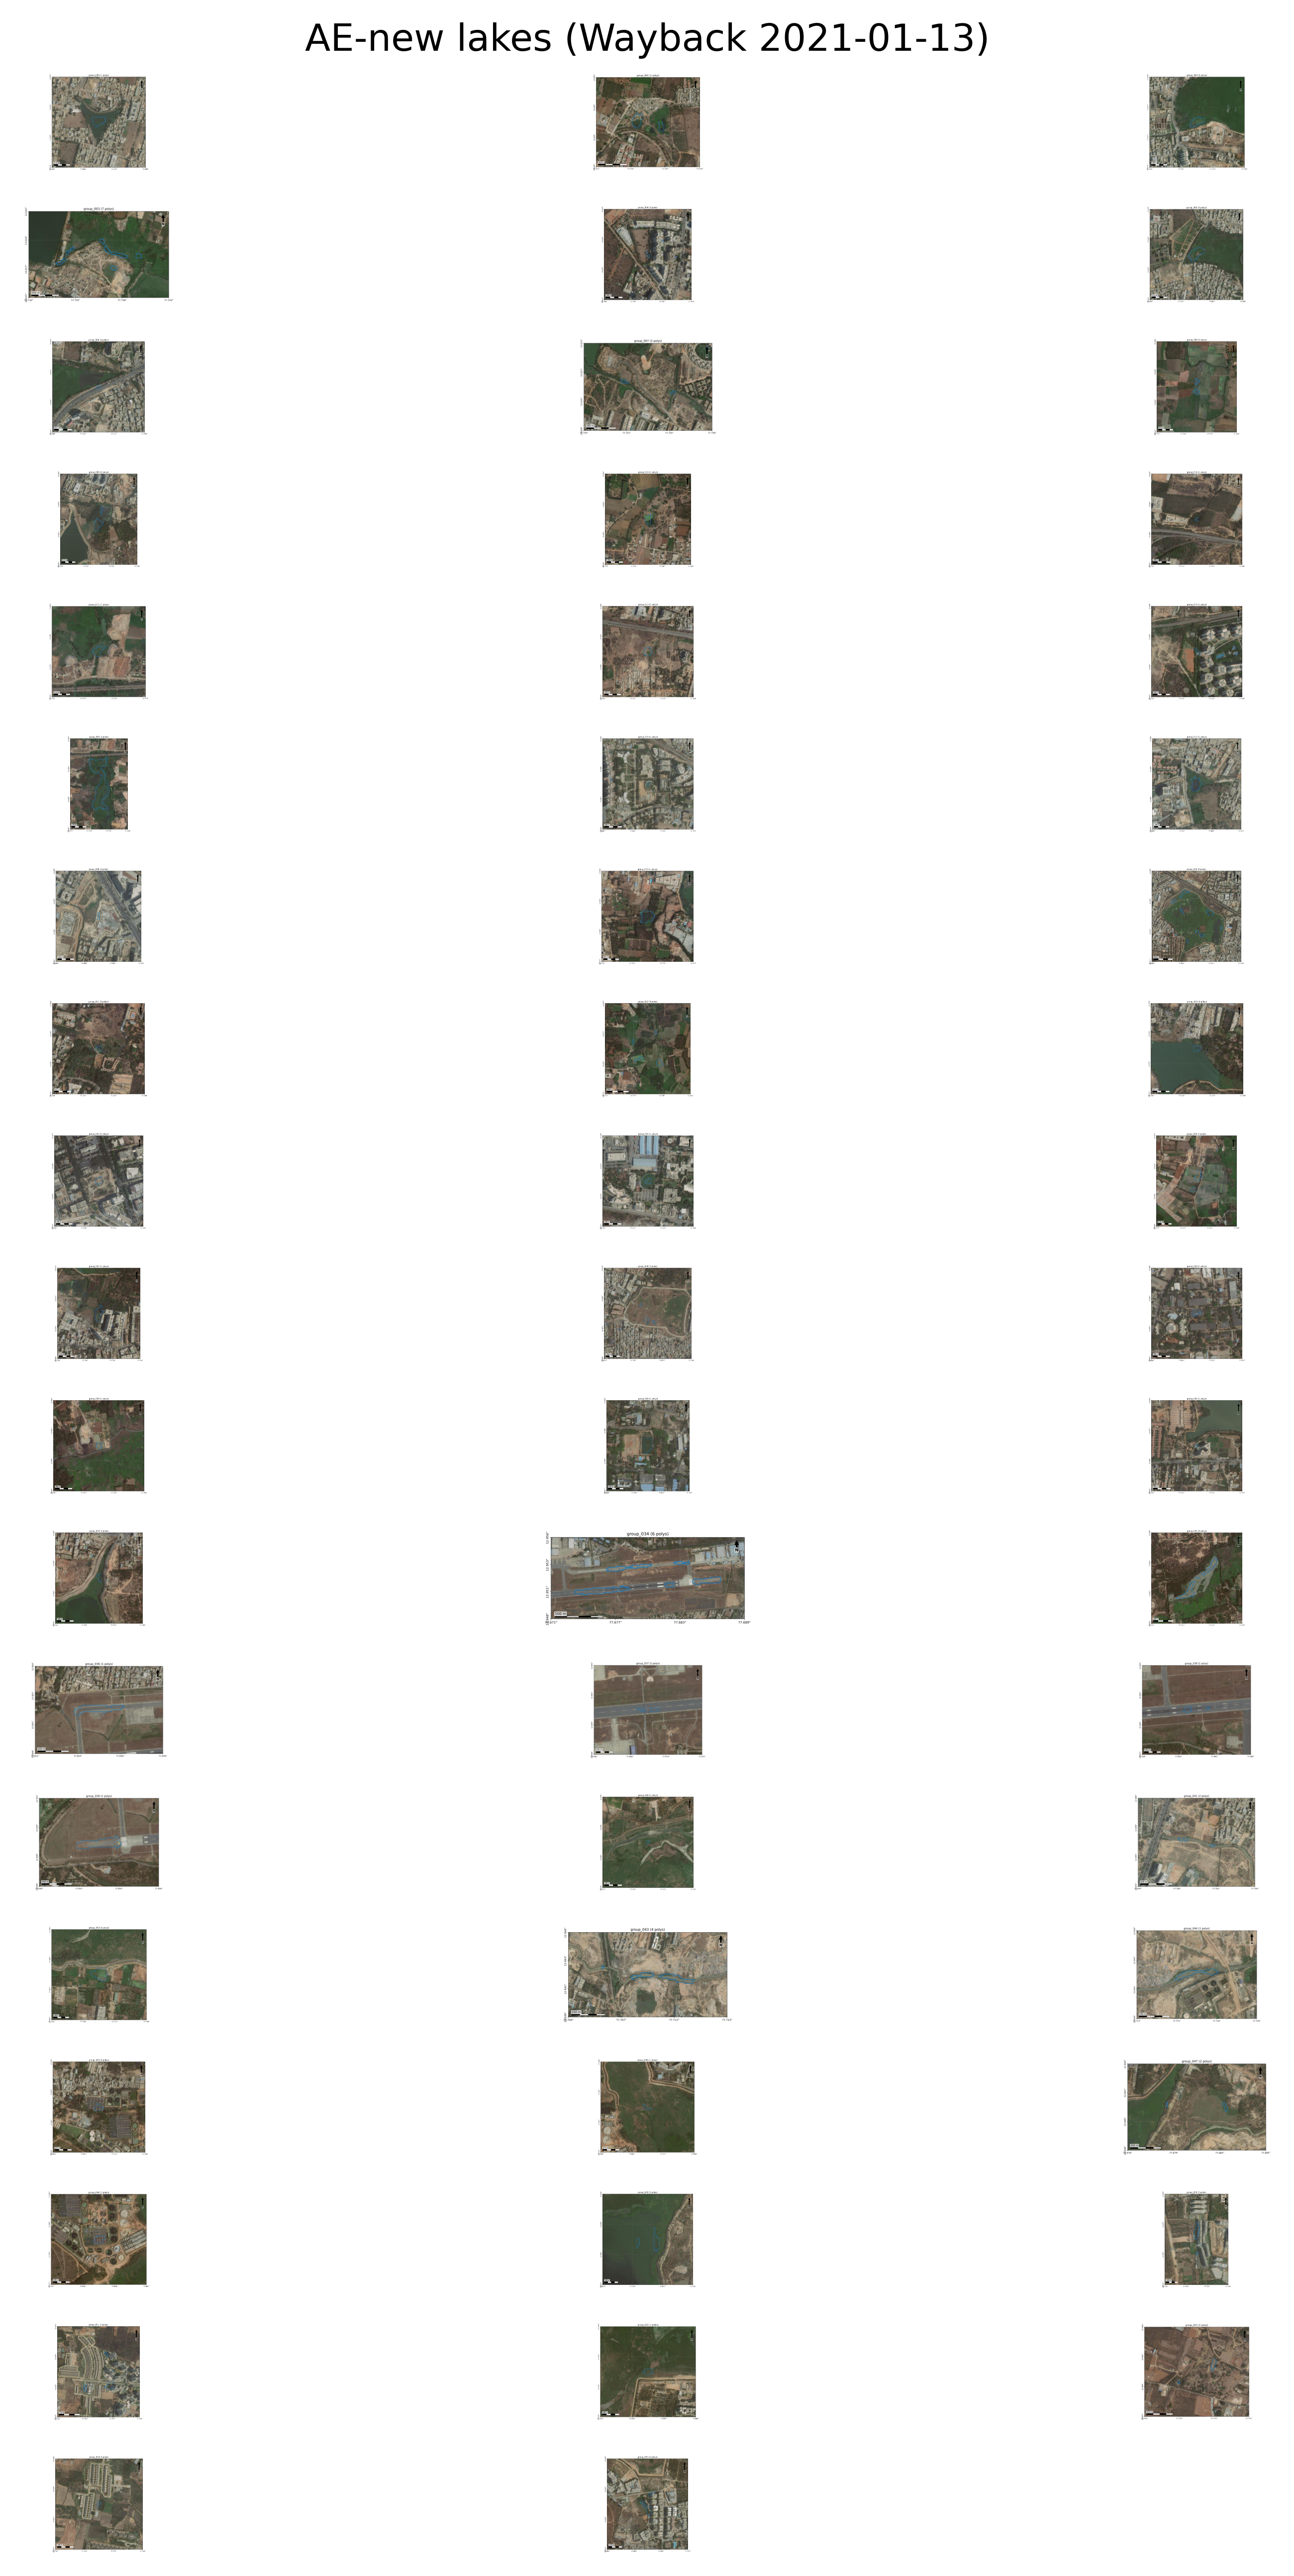

In [15]:
from lake_maps_comparison.wayback_export import export_wayback_page, ExportStyle


style = ExportStyle(
    pad_m=250,
    dpi=450,
    draw_coords=True,
    draw_scalebar=True,
    draw_north_arrow=True,          # ✅ polygon thickness (change here)
)

out_png, out_pdf, used_panels = export_wayback_page(
    polygons_path=tmp_geojson,
    out_path_no_ext="/content/wayback_pngs/AE_new_ONE_PAGE_2021",
    wayback_date="2021-01-13",
    mode="grouped",
    group_eps_m=400,
    id_field="obj_id",
    style=style,
    ncols=3,
    page="A4",
    suptitle="AE-new lakes (Wayback 2021-01-13)"
)

out_png, out_pdf
fill_opacity=0.15

In [89]:
from lake_maps_comparison.wayback_export import export_wayback_page, ExportStyle

ImportError: cannot import name 'export_wayback_page' from 'lake_maps_comparison.wayback_export' (/content/useful_libs/lake_maps_comparison/wayback_export.py)

In [16]:
new_gdf

obj_id                                           geometry  px_count  \
1         3  POLYGON ((77.68667 13.0271, 77.68667 13.02683,...        35   
3         5  POLYGON ((77.75503 13.02306, 77.75503 13.02297...        49   
4         6  POLYGON ((77.75637 13.02252, 77.75637 13.02243...        17   
5         7  POLYGON ((77.72206 13.02207, 77.72206 13.02198...        37   
6         8  POLYGON ((77.73742 13.01946, 77.73742 13.01919...        14   
..      ...                                                ...       ...   
129     132  POLYGON ((77.77218 12.93098, 77.77218 12.93062...        20   
132     133  POLYGON ((77.76976 12.92954, 77.76976 12.92945...         3   
133     134  POLYGON ((77.73401 12.92766, 77.73401 12.9273,...         5   
134     135  POLYGON ((77.66457 12.92694, 77.66457 12.92685...         8   
135     136  POLYGON ((77.66385 12.92631, 77.66385 12.92622...        30   

     area_m2  area_ha  
1     3500.0     0.35  
3     4900.0     0.49  
4     1700.0     0.17  
5     3700.0     0.37  
6     1400.0     0.14  
..       ...      ...  
129   2000.0     0.20  
132    300.0     0.03  
133    500.0     0.05  
134    800.0     0.08  
135   3000.0     0.30  

[99 rows x 5 columns]